In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision

from datetime import datetime
from collections import OrderedDict

In [2]:
import pickle

In [3]:
PATH = Path("/data2/yinterian/multi-task-romain")

In [4]:
with open(PATH/"obs_df_train.pickle", 'rb') as f:
    train = pickle.load(f)

In [5]:
with open(PATH/"obs_df_valid.pickle", 'rb') as f:
    valid = pickle.load(f)

In [6]:
train.head()

,subject_id,gender,age,sapsi_first,sofa_first,care_unit,amine,sedation,ventilation,period,series,y_event,y_mean_abpm,is_val
0,10013,1,87,15,8,0,1,0,0,10,"[[85.0, 89.1, 106.8, 31.5, 52.2], [84.9, 88.2,...",1,62.465,0
1,10013,1,87,15,8,0,1,0,0,11,"[[85.9, 88.3, 123.2, 38.6, 63.2], [85.5, 91.7,...",1,56.505,0
2,10013,1,87,15,8,0,1,0,0,12,"[[85.6, 93.6, 108.4, 34.7, 55.9], [86.0, 93.9,...",1,60.52,0
3,10013,1,87,15,8,0,1,0,0,15,"[[86.9, 0.0, 95.3, 30.0, 48.5], [87.4, 0.0, 94...",1,55.23,0
4,10013,1,87,15,8,0,1,0,0,16,"[[87.3, 90.6, 105.9, 36.1, 55.9], [86.8, 91.0,...",1,57.965,0


In [7]:
valid.head()

,subject_id,gender,age,sapsi_first,sofa_first,care_unit,amine,sedation,ventilation,period,series,y_event,y_mean_abpm,is_val
221,10209,0,35,16,7,1,1,1,1,10,"[[101.1, 100.0, 149.3, 94.5, 115.7], [101.3, 1...",0,107.575,1
222,10209,0,35,16,7,1,1,1,1,102,"[[89.0, 100.0, 133.6, 69.2, 88.2], [89.1, 100....",0,90.04,1
223,10209,0,35,16,7,1,1,1,1,103,"[[89.8, 97.9, 141.9, 71.2, 89.9], [89.8, 97.5,...",0,96.515,1
224,10209,0,35,16,7,1,1,1,1,104,"[[89.4, 99.0, 159.3, 77.4, 98.1], [89.1, 99.3,...",0,97.355,1
225,10209,0,35,16,7,1,1,1,1,106,"[[87.0, 99.0, 166.9, 78.4, 101.6], [90.6, 99.0...",0,102.24,1


In [8]:
train.shape, valid.shape

((32256, 14), (7332, 14))

## Dataset

In [9]:
def get_mean_std_series(train):
    ss = np.concatenate(train.series.values)
    ss = ss.reshape(-1,5)
    return ss.mean(axis=0), ss.std(axis=0)

In [10]:
def get_mean_std_static(train):
    res = {}
    for name in ["age", "sapsi_first", "sofa_first"]:
        values = train[name].values
        res[name] = (values.mean(), values.std())
    res["series"] = get_mean_std_series(train)
    return res

In [11]:
norm_dict = get_mean_std_static(train)
norm_dict 

{'age': (67, 16.152217089222916),
 'sapsi_first': (16, 4.968204119744002),
 'sofa_first': (8, 4.153183597602336),
 'series': (array([ 85.78689748,  90.61373362, 118.25838821,  57.44024058,
          81.28476211]),
  array([16.91317423, 24.11194065, 31.60648773, 17.01183444, 20.30982141]))}

In [12]:
class MultiTask(Dataset):
    def __init__(self, df, norm_dict):
        """
        Args:
            df: dataframe with data
            norm_dict: mean and std of all variables to normalize
            
        """
        self.norm_dict = norm_dict
        self.df = df
        self.names = ["age", "sapsi_first", "sofa_first"] ## needs normalization
        self.names_binary = ["gender", "amine", "sedation", "ventilation"]

    def __getitem__(self, index):
        row = self.df.iloc[index,:]
        x_series = (row.series - self.norm_dict["series"][0])/self.norm_dict["series"][1]
        x_cont = [(row[name]-self.norm_dict[name][0])/self.norm_dict[name][1] for name in self.names]
        x_binary = [row[name] for name in self.names_binary]
        x_cat = row["care_unit"]
        x_cont = np.array(x_cont + x_binary)
        return x_series, x_cont, x_cat, row["y_event"], row["y_mean_abpm"]

    def __len__(self):
        return self.df.shape[0]

In [13]:
train_ds = MultiTask(train, norm_dict)
valid_ds = MultiTask(valid, norm_dict)

In [14]:
x1, x2, x3, y1, y2 = train_ds[0]

In [15]:
y2

62.465

In [23]:
batch_size = 10
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [24]:
x_series, x_cont, x_cat, y1, y2 = next(iter(train_dl))

In [25]:
x_series.shape

torch.Size([10, 60, 5])

In [26]:
x_cont.shape

torch.Size([10, 7])

In [27]:
gru = nn.GRU(5, 11, batch_first=True).cuda()

In [28]:
hts, ht = gru(x_series.float().cuda())
ht.shape

torch.Size([1, 10, 11])

In [30]:
ht[0].shape

torch.Size([10, 11])

In [31]:
hts.shape

torch.Size([10, 60, 11])

In [32]:
hidden_size = 100
embedding = nn.Embedding(3, 1).cuda()
gru = nn.GRU(5, hidden_size, bidirectional=True, batch_first=True).cuda()
num = hidden_size + 10 + 1
linear1 = nn.Linear(7, 10).cuda()
out1 = nn.Linear(num, 1).cuda()
out2 = nn.Linear(num, 1).cuda()
bn1 = nn.BatchNorm1d(10).cuda()

In [33]:
x_series, x_cont, x_cat, y1, y2 = next(iter(train_dl))
x_series = x_series.float().cuda()
x_cont = x_cont.float().cuda()
x_cat = x_cat.long().cuda()
y1 = y1.float().cuda()
y2 = y2.float().cuda()

In [34]:
_, ht = gru(x_series)

## Model

In [16]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [17]:
class EventModel(nn.Module):
    def __init__(self, hidden_size=100):
        super(EventModel, self).__init__()
        self.embedding = nn.Embedding(3, 1)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 10 + 1
        self.linear1 = nn.Linear(7, 10)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(10)

    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat = self.embedding(x_cat)
        x_cont = self.bn1(F.relu(self.linear1(x_cont))) 
        x = torch.cat((ht[-1], x_cat, x_cont), 1)
        return self.out1(x), self.out2(x)

In [18]:
class EventModel2(nn.Module):
    def __init__(self, hidden_size=100):
        super(EventModel2, self).__init__()
        self.embedding = nn.Embedding(3, 1)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 7 + 1
        self.linear1 = nn.Linear(7, 7)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(7)
        
    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat = self.embedding(x_cat)
        x_cont = self.bn1(F.relu(self.linear1(x_cont))) + x_cont
        x = torch.cat((ht[-1], x_cat, x_cont), 1)
        return self.out1(x), self.out2(x)

In [19]:
class EventModel3(nn.Module):
    def __init__(self, hidden_size=100):
        super(EventModel3, self).__init__()
        self.embedding = nn.Embedding(3, 1)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 7 + 1
        self.linear1 = nn.Linear(self.num, self.num)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(self.num)
        
    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat = self.embedding(x_cat)
        x = torch.cat((ht[-1], x_cat, x_cont), 1)
        x = self.bn1(F.relu(self.linear1(x)))
        return self.out1(x), self.out2(x)

In [20]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat1 = []
    ys1 = []
    y_hat2 = []
    ys2 = []
    for x_series, x_cont, x_cat, y1, y2 in valid_dl:
        batch = y1.shape[0]
        x_series = x_series.float().cuda()
        x_cont = x_cont.float().cuda()
        x_cat = x_cat.long().cuda()
        y1 = y1.float().cuda()
        y2 = y2.float().cuda()
        out1, out2 = model(x_series, x_cont, x_cat)
        log_loss = F.binary_cross_entropy_with_logits(out1, y1.unsqueeze(-1))
        mse_loss = F.mse_loss(out2, y2.unsqueeze(-1))
        loss = log_loss + mse_loss
        sum_loss += batch*(loss.item())
        total += batch
        y_hat1.append(out1.view(-1).detach().cpu().numpy())
        ys1.append(y1.view(-1).cpu().numpy())
        y_hat2.append(out2.view(-1).detach().cpu().numpy())
        ys2.append(y2.view(-1).cpu().numpy())
    
    y_hat1 = np.concatenate(y_hat1)
    y_hat2 = np.concatenate(y_hat2)
    ys1 = np.concatenate(ys1)
    ys2 = np.concatenate(ys2)
    r2 = metrics.r2_score(ys2, y_hat2)
    auc = metrics.roc_auc_score(ys1, y_hat1)
    return sum_loss/total, auc, r2

In [25]:
def train_epochs(model, train_dl, optimizer, filename, lr=1e-3, epochs = 30):
    prev_val_r2 = 0
    for i in range(epochs):
        sum_loss1 = 0
        sum_loss2 = 0
        total = 0
        for x_series, x_cont, x_cat, y1, y2 in train_dl:
            model.train()
            x_series = x_series.float().cuda()
            x_cont = x_cont.float().cuda()
            x_cat = x_cat.long().cuda()
            y1 = y1.float().cuda()
            y2 = y2.float().cuda()
            out1, out2 = model(x_series, x_cont, x_cat)
            log_loss = F.binary_cross_entropy_with_logits(out1, y1.unsqueeze(-1))
            mse_loss = F.mse_loss(out2, y2.unsqueeze(-1))
            loss = log_loss + mse_loss
            sum_loss1 += len(y1) * log_loss.item()
            sum_loss2 += len(y1) * mse_loss.item()
            total += len(y1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if i % 1 == 0:
            val_loss, val_auc, val_r2 = val_metrics(model, valid_dl)
            print("\tTrain loss: {:.3f} {:.3f} valid loss: {:.3f} valid auc {:.3f} valid r2 {:.3f}".format(
                sum_loss1/total, sum_loss2/total, val_loss, val_auc, val_r2))
            
        if val_r2 > prev_val_r2:
            prev_val_r2 = val_r2
            if val_r2 > 0.7:
                path = "{0}/models/{1}_r2_{2:.0f}_auc_{3:.0f}.pth".format(PATH, filename, 100*val_r2, 100*val_auc) 
                save_model(model, path)
                print(path)

In [22]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [44]:
model = EventModel().cuda()

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)

In [46]:
train_epochs(model, train_dl, optimizer, filename="model1", epochs=15)

	Train loss: 0.558 5540.801 valid loss: 3497.681 valid auc 0.892 valid r2 -9.719
	Train loss: 0.355 2283.166 valid loss: 832.262 valid auc 0.891 valid r2 -1.550
	Train loss: 0.344 411.508 valid loss: 275.807 valid auc 0.898 valid r2 0.156
	Train loss: 0.322 309.826 valid loss: 332.436 valid auc 0.887 valid r2 -0.018
	Train loss: 0.332 256.891 valid loss: 187.423 valid auc 0.875 valid r2 0.427
	Train loss: 0.340 159.971 valid loss: 176.174 valid auc 0.866 valid r2 0.461
	Train loss: 0.343 158.754 valid loss: 172.762 valid auc 0.884 valid r2 0.472
	Train loss: 0.335 145.260 valid loss: 154.841 valid auc 0.880 valid r2 0.526
	Train loss: 0.333 134.529 valid loss: 149.408 valid auc 0.878 valid r2 0.543
	Train loss: 0.325 129.455 valid loss: 143.152 valid auc 0.883 valid r2 0.562
	Train loss: 0.319 124.147 valid loss: 138.674 valid auc 0.888 valid r2 0.576
	Train loss: 0.317 121.214 valid loss: 134.927 valid auc 0.892 valid r2 0.587
	Train loss: 0.314 118.616 valid loss: 132.025 valid auc 0

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_dl, optimizer,filename="model1", epochs=20)

	Train loss: 0.460 126.937 valid loss: 124.748 valid auc 0.902 valid r2 0.619
	Train loss: 0.354 110.977 valid loss: 123.678 valid auc 0.904 valid r2 0.622
	Train loss: 0.331 107.793 valid loss: 119.566 valid auc 0.906 valid r2 0.634
	Train loss: 0.307 105.259 valid loss: 117.457 valid auc 0.906 valid r2 0.641
	Train loss: 0.298 102.716 valid loss: 114.973 valid auc 0.908 valid r2 0.649
	Train loss: 0.292 100.406 valid loss: 112.576 valid auc 0.910 valid r2 0.656
	Train loss: 0.288 97.998 valid loss: 110.091 valid auc 0.911 valid r2 0.663
	Train loss: 0.290 95.805 valid loss: 109.674 valid auc 0.910 valid r2 0.665
	Train loss: 0.289 94.075 valid loss: 108.451 valid auc 0.912 valid r2 0.669
	Train loss: 0.285 92.088 valid loss: 106.796 valid auc 0.917 valid r2 0.674
	Train loss: 0.278 90.476 valid loss: 105.235 valid auc 0.921 valid r2 0.678
	Train loss: 0.279 89.003 valid loss: 106.356 valid auc 0.920 valid r2 0.675
	Train loss: 0.276 88.237 valid loss: 103.477 valid auc 0.920 valid r2

In [48]:
path = "{0}/models/model0_acc_92_r2_{1:.0f}.pth".format(PATH, 100*0.69) 
save_model(model, path)

In [50]:
# new try
model = EventModel().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=3e-5)
train_epochs(model, train_dl, optimizer, filename="model1", epochs=15)

	Train loss: 0.557 5656.964 valid loss: 3546.525 valid auc 0.840 valid r2 -9.868
	Train loss: 0.415 2248.717 valid loss: 862.392 valid auc 0.880 valid r2 -1.642
	Train loss: 0.373 401.649 valid loss: 275.263 valid auc 0.896 valid r2 0.157
	Train loss: 0.343 374.347 valid loss: 385.253 valid auc 0.892 valid r2 -0.180
	Train loss: 0.365 315.856 valid loss: 208.421 valid auc 0.870 valid r2 0.362
	Train loss: 0.356 173.524 valid loss: 193.626 valid auc 0.849 valid r2 0.408
	Train loss: 0.354 175.444 valid loss: 193.976 valid auc 0.861 valid r2 0.407
	Train loss: 0.345 164.000 valid loss: 169.304 valid auc 0.877 valid r2 0.482
	Train loss: 0.333 147.575 valid loss: 159.866 valid auc 0.883 valid r2 0.511
	Train loss: 0.328 140.912 valid loss: 156.455 valid auc 0.876 valid r2 0.522
	Train loss: 0.333 143.350 valid loss: 147.939 valid auc 0.873 valid r2 0.548
	Train loss: 0.329 133.951 valid loss: 148.193 valid auc 0.877 valid r2 0.547
	Train loss: 0.328 128.605 valid loss: 141.732 valid auc 0

In [51]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=3e-5)
train_epochs(model, train_dl, optimizer, filename="model1", epochs=20)

	Train loss: 0.499 118.792 valid loss: 128.645 valid auc 0.890 valid r2 0.607
	Train loss: 0.387 111.989 valid loss: 123.553 valid auc 0.893 valid r2 0.622
	Train loss: 0.337 105.941 valid loss: 116.206 valid auc 0.898 valid r2 0.645
	Train loss: 0.317 102.208 valid loss: 115.273 valid auc 0.897 valid r2 0.648
	Train loss: 0.311 98.768 valid loss: 111.532 valid auc 0.904 valid r2 0.659
	Train loss: 0.302 96.312 valid loss: 108.222 valid auc 0.907 valid r2 0.669
	Train loss: 0.293 94.110 valid loss: 107.289 valid auc 0.910 valid r2 0.672
	Train loss: 0.290 92.537 valid loss: 105.342 valid auc 0.912 valid r2 0.678
	Train loss: 0.285 90.009 valid loss: 104.592 valid auc 0.914 valid r2 0.680
	Train loss: 0.283 89.789 valid loss: 103.115 valid auc 0.916 valid r2 0.685
	Train loss: 0.282 87.671 valid loss: 103.057 valid auc 0.920 valid r2 0.685
	Train loss: 0.281 86.796 valid loss: 102.229 valid auc 0.920 valid r2 0.688
	Train loss: 0.285 85.696 valid loss: 101.696 valid auc 0.918 valid r2 0

### Model 2

In [20]:
model = EventModel2().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=3e-5)
train_epochs(model, train_dl, optimizer, filename="model2",epochs=15)

	Train loss: 0.572 5471.378 valid loss: 3427.993 valid auc 0.851 valid r2 -9.505
	Train loss: 0.410 2313.734 valid loss: 905.162 valid auc 0.882 valid r2 -1.773
	Train loss: 0.367 462.863 valid loss: 221.941 valid auc 0.892 valid r2 0.321
	Train loss: 0.336 277.959 valid loss: 380.718 valid auc 0.888 valid r2 -0.166
	Train loss: 0.343 287.511 valid loss: 213.315 valid auc 0.891 valid r2 0.347
	Train loss: 0.315 171.657 valid loss: 166.768 valid auc 0.894 valid r2 0.490
	Train loss: 0.315 154.887 valid loss: 170.290 valid auc 0.895 valid r2 0.479
	Train loss: 0.307 150.405 valid loss: 160.113 valid auc 0.899 valid r2 0.510
	Train loss: 0.305 138.413 valid loss: 149.179 valid auc 0.902 valid r2 0.544
	Train loss: 0.301 131.003 valid loss: 141.377 valid auc 0.903 valid r2 0.568
	Train loss: 0.300 125.492 valid loss: 137.444 valid auc 0.905 valid r2 0.580
	Train loss: 0.298 123.243 valid loss: 132.596 valid auc 0.908 valid r2 0.595
	Train loss: 0.297 118.913 valid loss: 130.229 valid auc 0

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=3e-5)
train_epochs(model, train_dl, optimizer, filename="model2", epochs=20)

	Train loss: 0.406 112.307 valid loss: 119.428 valid auc 0.913 valid r2 0.635
	Train loss: 0.333 107.575 valid loss: 115.385 valid auc 0.914 valid r2 0.647
	Train loss: 0.322 100.261 valid loss: 109.791 valid auc 0.914 valid r2 0.664
	Train loss: 0.303 98.183 valid loss: 108.314 valid auc 0.907 valid r2 0.669
	Train loss: 0.302 95.526 valid loss: 107.107 valid auc 0.908 valid r2 0.673
	Train loss: 0.293 94.367 valid loss: 105.183 valid auc 0.910 valid r2 0.679
	Train loss: 0.285 91.069 valid loss: 103.386 valid auc 0.912 valid r2 0.684
	Train loss: 0.284 89.615 valid loss: 101.989 valid auc 0.915 valid r2 0.688
	Train loss: 0.281 88.145 valid loss: 101.753 valid auc 0.916 valid r2 0.689
	Train loss: 0.278 87.158 valid loss: 102.721 valid auc 0.916 valid r2 0.686
	Train loss: 0.275 86.722 valid loss: 100.385 valid auc 0.918 valid r2 0.693
	Train loss: 0.274 85.826 valid loss: 102.717 valid auc 0.918 valid r2 0.686
	Train loss: 0.273 84.735 valid loss: 99.850 valid auc 0.920 valid r2 0.6

## Model 3

In [26]:
model = EventModel3().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=3e-5)
train_epochs(model, train_dl, optimizer, filename="model3", epochs=15)

	Train loss: 0.559 6478.740 valid loss: 6720.069 valid auc 0.903 valid r2 -19.594
	Train loss: 0.400 3865.623 valid loss: 876.103 valid auc 0.884 valid r2 -1.684
	Train loss: 0.403 541.460 valid loss: 423.335 valid auc 0.912 valid r2 -0.295
	Train loss: 0.368 680.451 valid loss: 316.751 valid auc 0.916 valid r2 0.031
	Train loss: 0.317 159.442 valid loss: 311.143 valid auc 0.922 valid r2 0.048
	Train loss: 0.302 215.688 valid loss: 238.342 valid auc 0.917 valid r2 0.270
	Train loss: 0.287 108.489 valid loss: 109.523 valid auc 0.917 valid r2 0.665
	Train loss: 0.287 103.985 valid loss: 124.528 valid auc 0.919 valid r2 0.619
	Train loss: 0.280 80.234 valid loss: 112.783 valid auc 0.924 valid r2 0.655
	Train loss: 0.280 80.430 valid loss: 105.465 valid auc 0.923 valid r2 0.678
	Train loss: 0.275 71.782 valid loss: 106.589 valid auc 0.923 valid r2 0.674
	Train loss: 0.268 71.114 valid loss: 104.627 valid auc 0.925 valid r2 0.680
	Train loss: 0.264 68.091 valid loss: 100.808 valid auc 0.926

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=3e-5)
train_epochs(model, train_dl, optimizer, filename="model3", epochs=20)

	Train loss: 0.298 80.243 valid loss: 103.825 valid auc 0.922 valid r2 0.683
	Train loss: 0.284 71.912 valid loss: 101.770 valid auc 0.926 valid r2 0.689
	Train loss: 0.267 68.668 valid loss: 102.958 valid auc 0.924 valid r2 0.685
	Train loss: 0.268 65.787 valid loss: 99.084 valid auc 0.926 valid r2 0.697
	Train loss: 0.265 62.985 valid loss: 97.094 valid auc 0.927 valid r2 0.703
	Train loss: 0.263 62.857 valid loss: 97.487 valid auc 0.928 valid r2 0.702
	Train loss: 0.261 60.795 valid loss: 102.769 valid auc 0.926 valid r2 0.686
	Train loss: 0.261 60.218 valid loss: 100.094 valid auc 0.926 valid r2 0.694
	Train loss: 0.261 59.393 valid loss: 100.960 valid auc 0.925 valid r2 0.691
	Train loss: 0.261 59.544 valid loss: 101.426 valid auc 0.925 valid r2 0.690
	Train loss: 0.260 59.148 valid loss: 103.277 valid auc 0.928 valid r2 0.684
	Train loss: 0.259 59.859 valid loss: 106.057 valid auc 0.926 valid r2 0.676
	Train loss: 0.263 58.990 valid loss: 106.090 valid auc 0.927 valid r2 0.676
	T

## Model 4

In [27]:
class EventModel4(nn.Module):
    def __init__(self, hidden_size=100, num2=50):
        super(EventModel4, self).__init__()
        self.embedding = nn.Embedding(3, 1)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num1 = hidden_size + 7 + 1
        self.num2 = num2
        self.linear1 = nn.Linear(self.num1, self.num2)
        self.linear2 = nn.Linear(self.num2, self.num2)
        self.out1 = nn.Linear(self.num2, 1)
        self.out2 = nn.Linear(self.num2, 1)
        self.bn1 = nn.BatchNorm1d(self.num2)
        self.bn2 = nn.BatchNorm1d(self.num2)
        
    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat = self.embedding(x_cat)
        x = torch.cat((ht[-1], x_cat, x_cont), 1)
        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))
        return self.out1(x), self.out2(x)

In [28]:
model = EventModel4().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=3e-5)
train_epochs(model, train_dl, optimizer, filename="model4", epochs=15)

	Train loss: 0.644 6727.855 valid loss: 6425.686 valid auc 0.914 valid r2 -18.691
	Train loss: 0.362 5981.286 valid loss: 5965.913 valid auc 0.918 valid r2 -17.282
	Train loss: 0.286 4673.132 valid loss: 4095.199 valid auc 0.907 valid r2 -11.551
	Train loss: 0.408 2928.703 valid loss: 2970.744 valid auc 0.890 valid r2 -8.104
	Train loss: 0.426 1138.616 valid loss: 473.311 valid auc 0.870 valid r2 -0.449
	Train loss: 0.286 168.259 valid loss: 184.248 valid auc 0.918 valid r2 0.436
	Train loss: 0.279 198.884 valid loss: 292.111 valid auc 0.920 valid r2 0.106
	Train loss: 0.279 221.210 valid loss: 104.622 valid auc 0.925 valid r2 0.680
	Train loss: 0.269 91.116 valid loss: 115.318 valid auc 0.924 valid r2 0.648
	Train loss: 0.269 80.125 valid loss: 142.325 valid auc 0.922 valid r2 0.565
	Train loss: 0.268 85.085 valid loss: 111.255 valid auc 0.924 valid r2 0.660
	Train loss: 0.266 70.593 valid loss: 99.771 valid auc 0.922 valid r2 0.695
	Train loss: 0.268 67.891 valid loss: 97.212 valid a

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=3e-5)
train_epochs(model, train_dl, optimizer, filename="model4", epochs=15)

	Train loss: 0.272 71.874 valid loss: 107.673 valid auc 0.922 valid r2 0.671
	Train loss: 0.272 69.203 valid loss: 99.756 valid auc 0.922 valid r2 0.695
	Train loss: 0.268 65.662 valid loss: 97.234 valid auc 0.926 valid r2 0.703
/data2/yinterian/multi-task-romain/models/model4_r2_70_auc_93.pth
	Train loss: 0.264 63.336 valid loss: 97.215 valid auc 0.924 valid r2 0.703
	Train loss: 0.267 63.886 valid loss: 101.242 valid auc 0.926 valid r2 0.691
	Train loss: 0.262 61.971 valid loss: 99.132 valid auc 0.924 valid r2 0.697
	Train loss: 0.265 60.070 valid loss: 98.696 valid auc 0.926 valid r2 0.698
	Train loss: 0.264 60.566 valid loss: 104.278 valid auc 0.924 valid r2 0.681
	Train loss: 0.263 59.844 valid loss: 99.391 valid auc 0.928 valid r2 0.696
	Train loss: 0.263 59.616 valid loss: 102.974 valid auc 0.925 valid r2 0.685
	Train loss: 0.262 58.269 valid loss: 106.032 valid auc 0.926 valid r2 0.676
	Train loss: 0.261 57.311 valid loss: 101.623 valid auc 0.927 valid r2 0.689
	Train loss: 0.2

## Calibration plot

In [50]:
with open(PATH/"obs_df_valid.pickle", 'rb') as f:
    valid = pickle.load(f)

In [31]:
path = PATH/"models/model4_r2_70_auc_93.pth"
model = EventModel4().cuda()
load_model(model, path)

In [73]:
def pick_obs_per_patient(valid, k=2):
    """ Picks sample from valid up to k per patient.
    """
    valid_sample = valid.groupby("subject_id", group_keys=False).apply(lambda x: x.sample(min(len(x), k)))
    return valid_sample

In [74]:
valid_sample = pick_obs_per_patient(valid, k=2)
valid_sample.shape, valid.shape

((311, 14), (7332, 14))

In [75]:
val_small_ds = MultiTask(valid_sample, norm_dict)
val_small_dl = DataLoader(val_small_ds, batch_size=311)

In [76]:
val_metrics(model, val_small_dl)

(58.35871505737305, 0.9121883321229727, 0.7806261142805457)

In [77]:
def predict_one_batch(model, dl):
    for x_series, x_cont, x_cat, y1, y2 in dl:
        x_series = x_series.float().cuda()
        x_cont = x_cont.float().cuda()
        x_cat = x_cat.long().cuda()
        y1 = y1.float().cuda()
        y2 = y2.float().cuda()
        out1, out2 = model(x_series, x_cont, x_cat)
    return out1.detach().cpu().numpy(), out2.detach().cpu().numpy(), y1.detach().cpu().numpy(), y2.detach().cpu().numpy()

In [78]:
out1, out2, y1, y2 = predict_one_batch(model, val_small_dl)

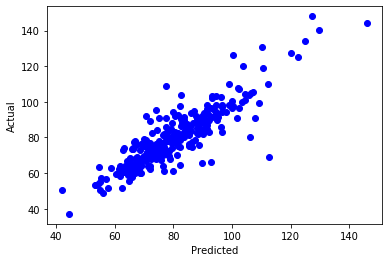

In [79]:
plt.plot(out2, y2, 'bo')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [84]:
y1.mean(), (out1 > 0.5).mean()

(0.21864952, 0.2057877813504823)